# Data Preparation and Graph Construction for Community Detection

This notebook demonstrates how to prepare data and construct graphs for community detection experiments. We'll cover:

1. Loading data from various sources
2. Creating graphs from different data types
3. Generating synthetic graphs with known community structure
4. Computing graph statistics
5. Visualizing graphs with community information

In [1]:
import sys
import os
import numpy as np
import torch
import polars as pl
import rustworkx as rx
import networkx as nx  # Still needed for some visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from typing import Dict, List, Optional, Tuple, Union, Any
warnings.filterwarnings('ignore')

# Import from data_prep module
from community_detection.data_prep import (
    load_data, create_graph_from_edgelist, create_graph_from_adjacency,
    plot_graph, generate_synthetic_graph,
    compute_graph_statistics, display_graph_statistics
)

# Try to import rwx_to_pyg from gnn_community_detection
try:
    from community_detection.gnn_community_detection import rwx_to_pyg
    print("Successfully imported rwx_to_pyg from gnn_community_detection module")
except ImportError:
    # Define rwx_to_pyg function locally if import fails
    print("Failed to import rwx_to_pyg, will define it locally when needed")

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool'}


2025-03-31 15:44:54.613944: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743450294.627616  550975 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743450294.631857  550975 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743450294.642592  550975 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743450294.642606  550975 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743450294.642607  550975 computation_placer.cc:177] computation placer alr

Successfully imported rwx_to_pyg from gnn_community_detection module


# Import directly from gnn_community_detection if available
try:
    from community_detection.gnn_community_detection import rwx_to_pyg
    GNN_MODULES_AVAILABLE = True
except ImportError:
    GNN_MODULES_AVAILABLE = False
    print("GNN modules not available. Will define rwx_to_pyg locally.")

Generating a Stochastic Block Model graph...


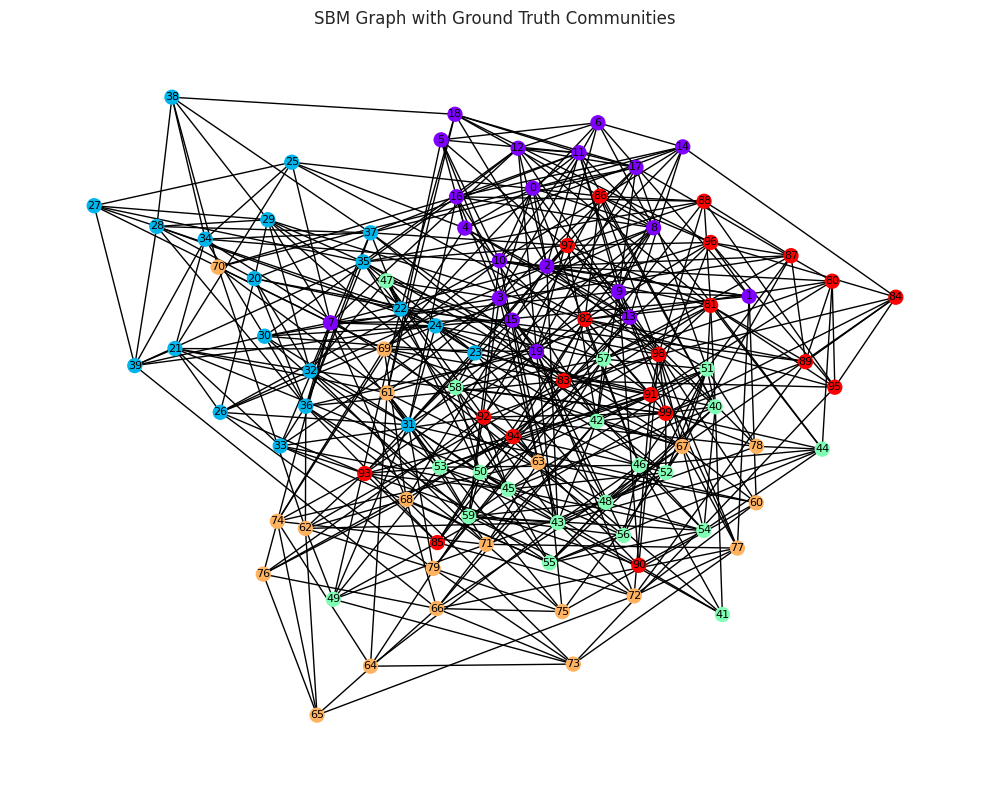

In [2]:
# 1.1 Generate a Stochastic Block Model (SBM) graph
print("Generating a Stochastic Block Model graph...")
n_communities = 5
G_sbm, ground_truth_sbm = generate_synthetic_graph(
    'sbm', 
    n_nodes=100, 
    n_communities=n_communities,
    p_in=0.3,  # probability of edge within community
    p_out=0.05  # probability of edge between communities
)

# Visualize the SBM graph with ground truth communities
plot_graph(G_sbm, community_attr='community', title="SBM Graph with Ground Truth Communities")

GRAPH STATISTICS
Number of nodes: 100
Number of edges: 491
Graph density: 0.0992
Average degree: 9.8200
Minimum degree: 5
Maximum degree: 19
Average clustering coefficient: 0.1485
Diameter: N/A (Error: module 'rustworkx' has no attribute 'diameter')
Average shortest path length: N/A (Error: module 'rustworkx' has no attribute 'diameter')


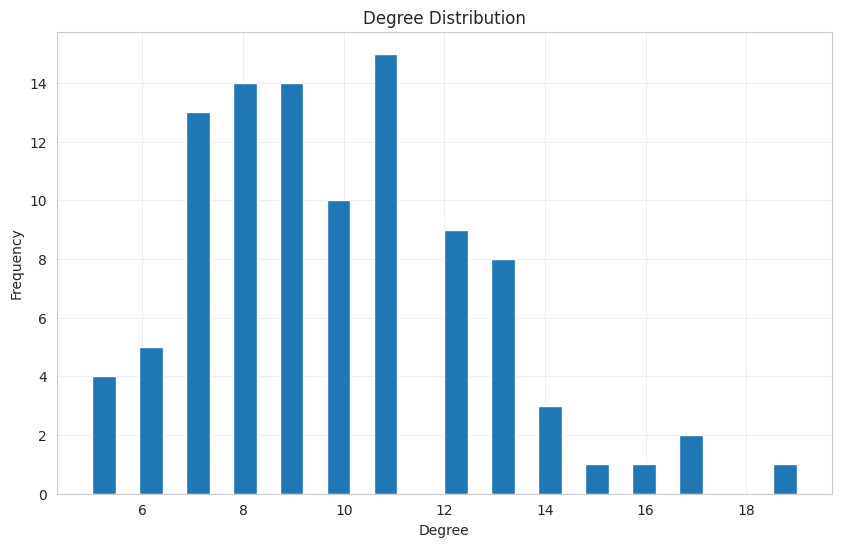

In [3]:
# 1.2 Compute and display graph statistics
stats_sbm = compute_graph_statistics(G_sbm)
display_graph_statistics(stats_sbm)

## 2. Generating Other Types of Synthetic Graphs

Let's explore other types of synthetic graphs that are commonly used in community detection research.

Generating a Newman-Watts-Strogatz small-world network...


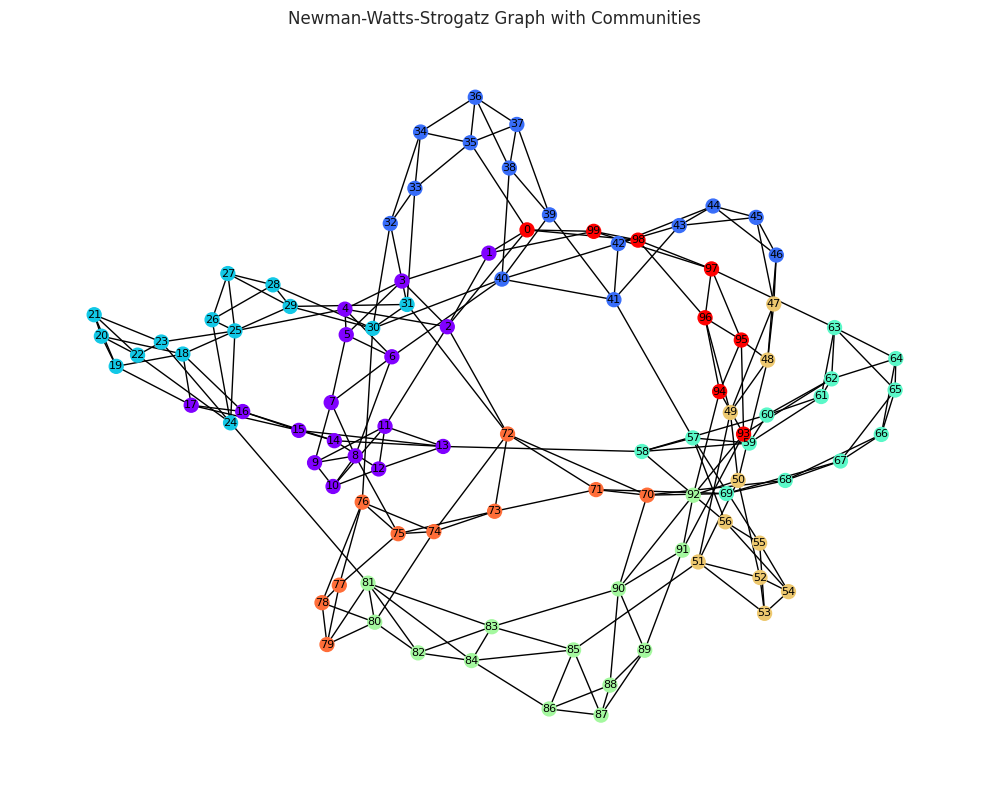

In [4]:
# 2.1 Generate a Newman-Watts-Strogatz small-world network
print("Generating a Newman-Watts-Strogatz small-world network...")
G_nws, ground_truth_nws = generate_synthetic_graph(
    'nws', 
    n_nodes=100, 
    k=5,  # Each node connected to k nearest neighbors
    p=0.1  # Probability of rewiring
)

# Visualize the NWS graph with detected communities
plot_graph(G_nws, community_attr='community', title="Newman-Watts-Strogatz Graph with Communities")

Generating a Barabási-Albert scale-free network...


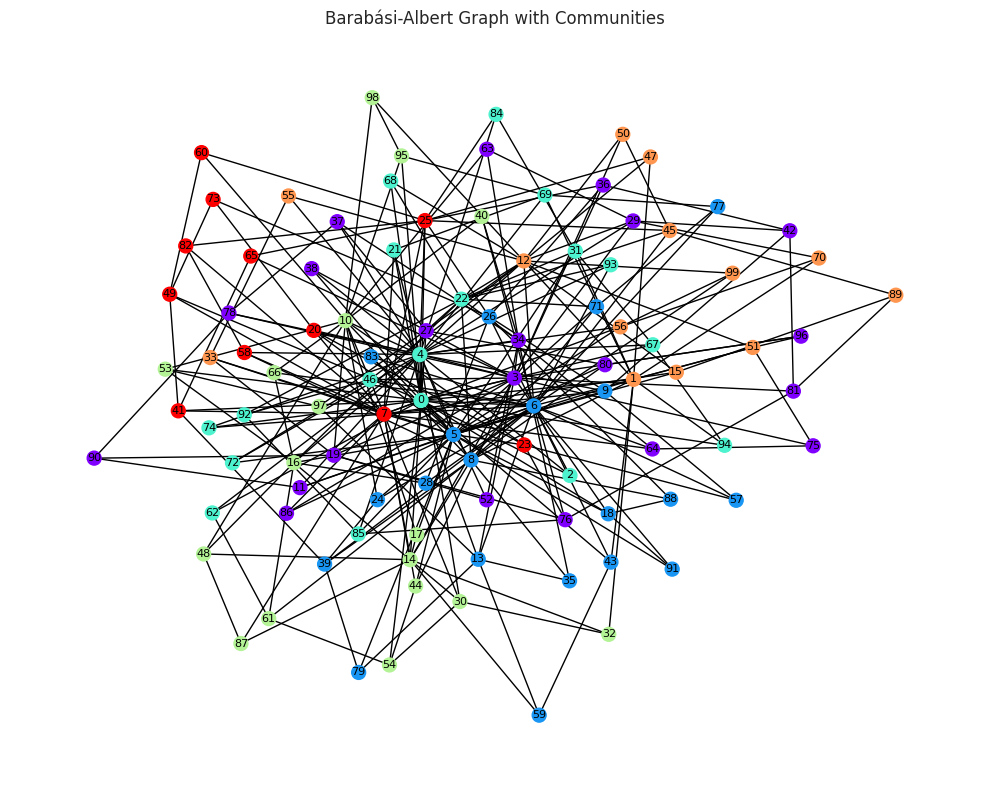

In [5]:
# 2.2 Generate a Barabási-Albert scale-free network
print("Generating a Barabási-Albert scale-free network...")
G_ba, ground_truth_ba = generate_synthetic_graph(
    'ba', 
    n_nodes=100, 
    m=3  # Number of edges to attach from a new node
)

# Visualize the BA graph with detected communities
plot_graph(G_ba, community_attr='community', title="Barabási-Albert Graph with Communities")

## 3. Creating Graphs from Edge Lists

Many real-world datasets are provided as edge lists. Let's see how to create a graph from such data.

Edge list data:
shape: (5, 3)
┌────────┬────────┬────────┐
│ source ┆ target ┆ weight │
│ ---    ┆ ---    ┆ ---    │
│ i64    ┆ i64    ┆ f64    │
╞════════╪════════╪════════╡
│ 0      ┆ 1      ┆ 1.0    │
│ 0      ┆ 2      ┆ 0.5    │
│ 1      ┆ 2      ┆ 0.8    │
│ 1      ┆ 3      ┆ 1.2    │
│ 2      ┆ 3      ┆ 0.7    │
└────────┴────────┴────────┘


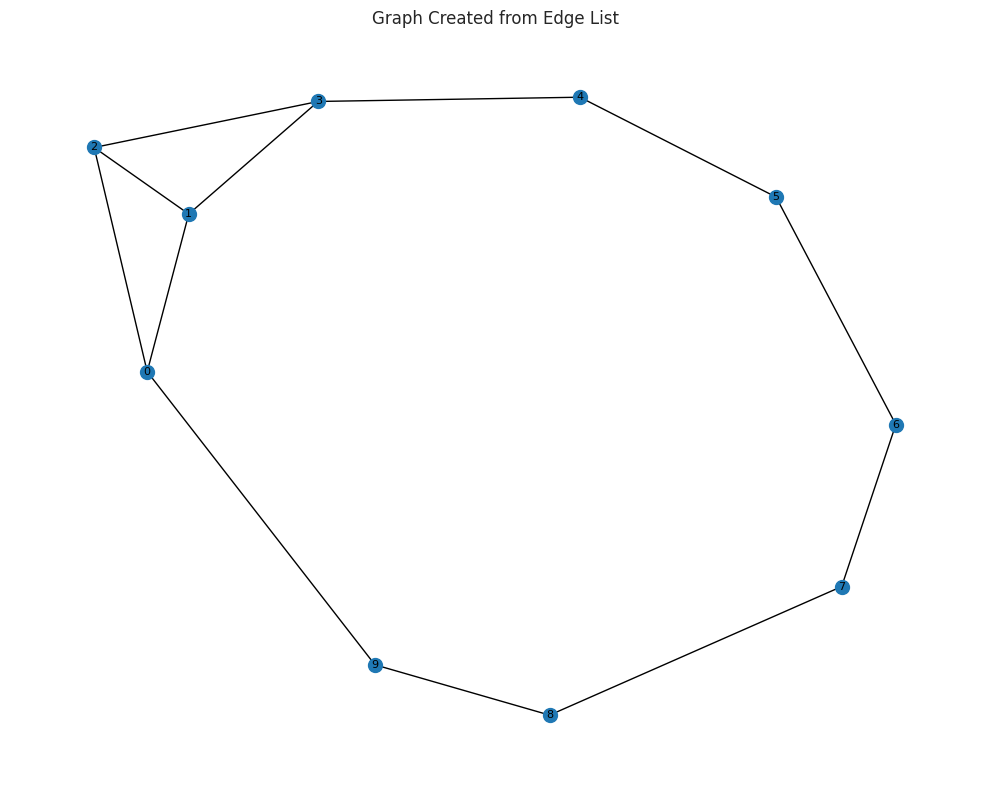

In [6]:
# 3.1 Create a simple edge list DataFrame
edge_data = {
    'source': [0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'target': [1, 2, 2, 3, 3, 4, 5, 6, 7, 8, 9, 0],
    'weight': [1.0, 0.5, 0.8, 1.2, 0.7, 0.9, 1.1, 0.6, 1.3, 0.4, 1.5, 0.3]
}
# Convert to polars DataFrame
edgelist_df = pl.DataFrame(edge_data)
print("Edge list data:")
print(edgelist_df.head())

# 3.2 Create a graph from the edge list
G_edgelist = create_graph_from_edgelist(edgelist_df, directed=False, weighted=True)

# Visualize the graph
plot_graph(G_edgelist, title="Graph Created from Edge List")

## 4. Creating Graphs from Adjacency Matrices

Another common format for graph data is the adjacency matrix.

Adjacency matrix:
tensor([[0, 1, 1, 0, 0],
        [1, 0, 1, 1, 0],
        [1, 1, 0, 1, 1],
        [0, 1, 1, 0, 1],
        [0, 0, 1, 1, 0]])


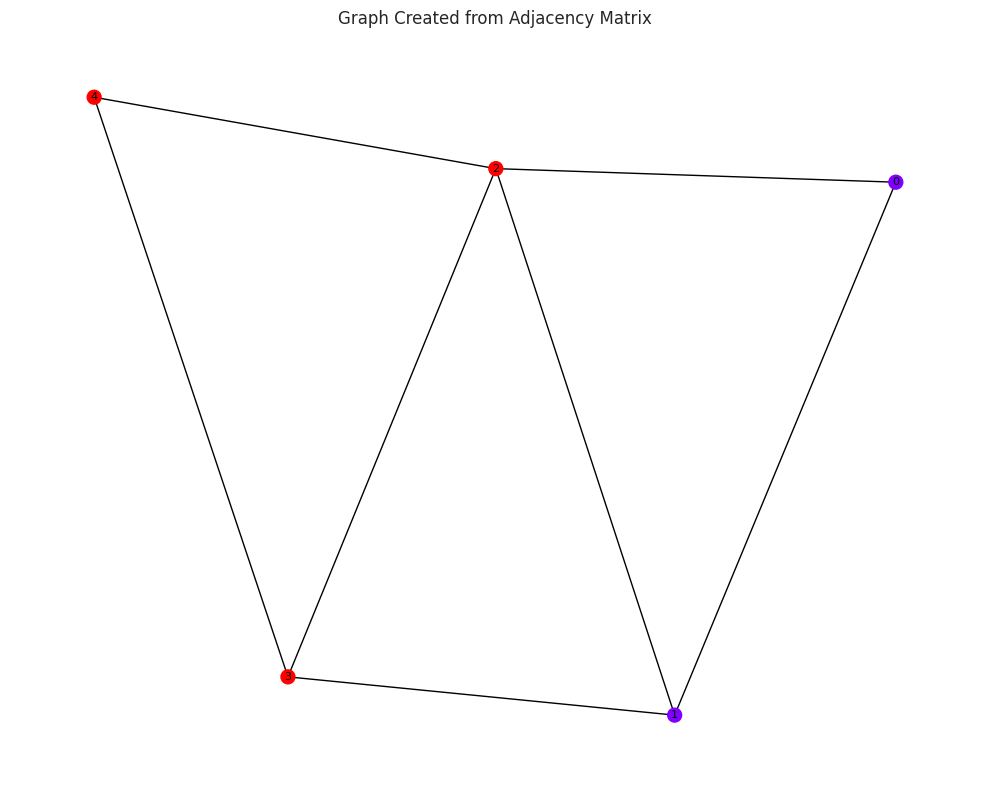

In [7]:
# 4.1 Create a simple adjacency matrix
adj_matrix = torch.tensor([
    [0, 1, 1, 0, 0],
    [1, 0, 1, 1, 0],
    [1, 1, 0, 1, 1],
    [0, 1, 1, 0, 1],
    [0, 0, 1, 1, 0]
])
print("Adjacency matrix:")
print(adj_matrix)

# 4.2 Create node features and labels
node_features = torch.rand(5, 3)  # 5 nodes, 3 features per node
node_labels = torch.tensor([0, 0, 1, 1, 1])  # Two communities

# 4.3 Create a graph from the adjacency matrix with features and labels
G_adj = create_graph_from_adjacency(adj_matrix, node_features, node_labels)

# Visualize the graph with communities
plot_graph(G_adj, community_attr='community', title="Graph Created from Adjacency Matrix")

# Intentionally leave this cell blank - it's no longer needed
# The rwx_to_pyg function is now defined in cell 13 if it's not already available from imports

In [8]:
# Check if PyTorch Geometric is available
try:
    import torch_geometric
    from torch_geometric.data import Data
    TORCH_GEOMETRIC_AVAILABLE = True
except ImportError:
    TORCH_GEOMETRIC_AVAILABLE = False
    print("PyTorch Geometric not available. Skipping this section.")

if TORCH_GEOMETRIC_AVAILABLE:
    # Define rwx_to_pyg here if it doesn't exist (backup definition)
    if 'rwx_to_pyg' not in globals():
        # This is a simplified version without detailed error handling
        print("Using local definition of rwx_to_pyg")
        def rwx_to_pyg(G, node_features=None):
            # Get edges as tensor
            edge_list = []
            for edge in G.edge_list():
                edge_list.append((edge[0], edge[1]))
            
            edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
            if isinstance(G, rx.PyGraph):
                edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
            
            # Get node features
            if node_features is not None:
                x = node_features
            else:
                node_degrees = [G.degree(i) for i in range(len(G))]
                max_degree = max(node_degrees) if node_degrees else 0
                x = torch.zeros((len(G), max_degree + 1))
                for i, degree in enumerate(node_degrees):
                    x[i, degree] = 1
            
            # Get community labels
            labels = []
            for i in range(len(G)):
                node_data = G.get_node_data(i)
                if node_data and isinstance(node_data, dict) and 'community' in node_data:
                    labels.append(node_data['community'])
            
            y = torch.tensor(labels, dtype=torch.long) if labels else None
            
            # Create Data object
            return Data(x=x, edge_index=edge_index, y=y)
    
    # 5.1 Convert the SBM graph to PyTorch Geometric format
    pyg_data = rwx_to_pyg(G_sbm)
    
    # 5.2 Print information about the PyG data object
    print(f"PyTorch Geometric Data object information:")
    print(f"Number of nodes: {pyg_data.num_nodes}")
    print(f"Number of edges: {pyg_data.num_edges}")
    print(f"Node feature dimensions: {list(pyg_data.x.shape)}")
    if pyg_data.y is not None:
        print(f"Number of communities: {len(torch.unique(pyg_data.y))}")
    print(f"Edge index shape: {list(pyg_data.edge_index.shape)}")

PyTorch Geometric Data object information:
Number of nodes: 100
Number of edges: 982
Node feature dimensions: [100, 20]
Number of communities: 5
Edge index shape: [2, 982]


## 6. Saving Graphs for Later Use

Let's save our generated graphs for use in subsequent notebooks.

In [9]:
# Create a directory for saved graphs if it doesn't exist
os.makedirs('data', exist_ok=True)

# Import pickle module
import pickle

# Save the SBM graph
with open('data/sbm_graph.gpickle', 'wb') as f:
    pickle.dump(G_sbm, f)

# Save the NWS graph
with open('data/nws_graph.gpickle', 'wb') as f:
    pickle.dump(G_nws, f)

# Save the BA graph
with open('data/ba_graph.gpickle', 'wb') as f:
    pickle.dump(G_ba, f)

print("Graphs saved to the 'data' directory.")

Graphs saved to the 'data' directory.


## 7. Summary

In this notebook, we have:

1. Generated synthetic graphs with known community structure
   - Stochastic Block Model (SBM)
   - Newman-Watts-Strogatz small-world network
   - Barabási-Albert scale-free network
2. Created graphs from edge lists and adjacency matrices
3. Added node features and ground truth community labels
4. Converted RustWorkX graphs to PyTorch Geometric format
5. Saved graphs for use in subsequent analyses

These graphs will serve as the foundation for our community detection experiments in the following notebooks.